In [1]:
import numpy as np
import scipy.linalg as sp
import torch as th

import os, pdb, sys, json, glob, tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from itertools import product

sns.set_style('whitegrid')

sns.set_context('notebook')

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 200

%load_ext autoreload
%autoreload 2

dev = 'cuda'

In [2]:
from utils import *
from embed import *

models = ["wr-4-8", "allcnn-96-144", "fc-1024-512-256-128"]
opts = ["adam", "sgdn", "sgd"]

In [3]:
T = 45000
ts = []
for t in range(T):
    if t < T//10:
        if t % (T//100) == 0:
            ts.append(t)
    else:
        if t % (T//10) == 0 or (t == T-1):
            ts.append(t)
ts = np.array(ts)
tmap = {i:ts[i] for i in range(len(ts))}
pts = np.concatenate([np.arange(ts[i], ts[i+1], (ts[i+1]-ts[i]) // 5) for i in range(len(ts)-1)])
N = len(pts)

## Bhat vs InPCA

In [4]:
loc = 'results/models/new'
d = load_d(loc, cond={'bs':[200], 'aug':[True], 'wd':[0.0], 'bn':[True], 'm':models, 'opt':opts},
           avg_err=True, drop=True, probs=True)

d_avg = avg_model(d, groupby=['m', 'opt', 't'], probs=True, get_err=True, 
              update_d=True, compute_distance=False, dev='cuda')['d']
d = interpolate(d_avg, ts, pts, columns=['seed', 'm', 'opt', 'avg'], keys=['yh', 'yvh'], dev='cuda')

Index(['index', 'seed', 'm', 'opt', 'lr', 'wd', 'bn', 'aug', 'bs', 't', 'yh',
       'f', 'e', 'yvh', 'fv', 'ev', 'err', 'verr', 'favg', 'vfavg'],
      dtype='object') 1800


In [5]:
loc = 'inpca_results'
fn = 'yh_new_interpolate_with_avg'
w = th.load(os.path.join(loc,'w_%s.p'%fn))
r = th.load(os.path.join(loc,'r_%s.p'%fn))
dc = th.load(os.path.join(loc,'didx_%s.p'%fn)).reset_index()

In [61]:
from distance import dbhat, dinpca

dists = []
k = 'yh'
m = models[0]
o = opts[0]

s = 0.3
seeds = dc['seed'].unique()
for s1 in range(len(seeds)):
    for s2 in range(s1+1, len(seeds)):
        i1 = get_idx(dc, f"m=='{m}' & opt=='{o}' & seed=={seeds[s1]}")
        i2 = get_idx(dc, f"m=='{m}' & opt=='{o}' & seed=={seeds[s1]}")
        di = dinpca(th.Tensor(r['xp'][i1]), th.Tensor(r['xp'][i2]), th.Tensor(np.sign(r['e'])))
        db = dbhat(th.Tensor(np.stack(d.iloc[i1][k])), th.Tensor(np.stack(d.iloc[i2][k])))
        dists.append(dict(dist=di.cpu(), distf='inpca', s1=seeds[s1], s2=seeds[s2]))
        dists.append(dict(dist=db.cpu(), distf='bhat', s1=seeds[s1], s2=seeds[s2]))
#         kdist = (th.exp(-dist/(2*s**2)) * dist) / th.exp(-dist/(2*s**2)).sum(1)
#         for i in range(N):
#             for j in range(N):
#                 dists.append(dict(dist=di[i, j].item(),distf='inpca', m=m, opt=o, 
#                               tx=pts[i], ty=pts[j], key=k, s1=seeds[s1], s2=seeds[s2]))
#                 dists.append(dict(dist=db[i, j].item(),distf='bhat', m=m, opt=o, 
#                               tx=pts[i], ty=pts[j], key=k, s1=seeds[s1], s2=seeds[s2]))
dists = pd.DataFrame(dists)

<AxesSubplot:>

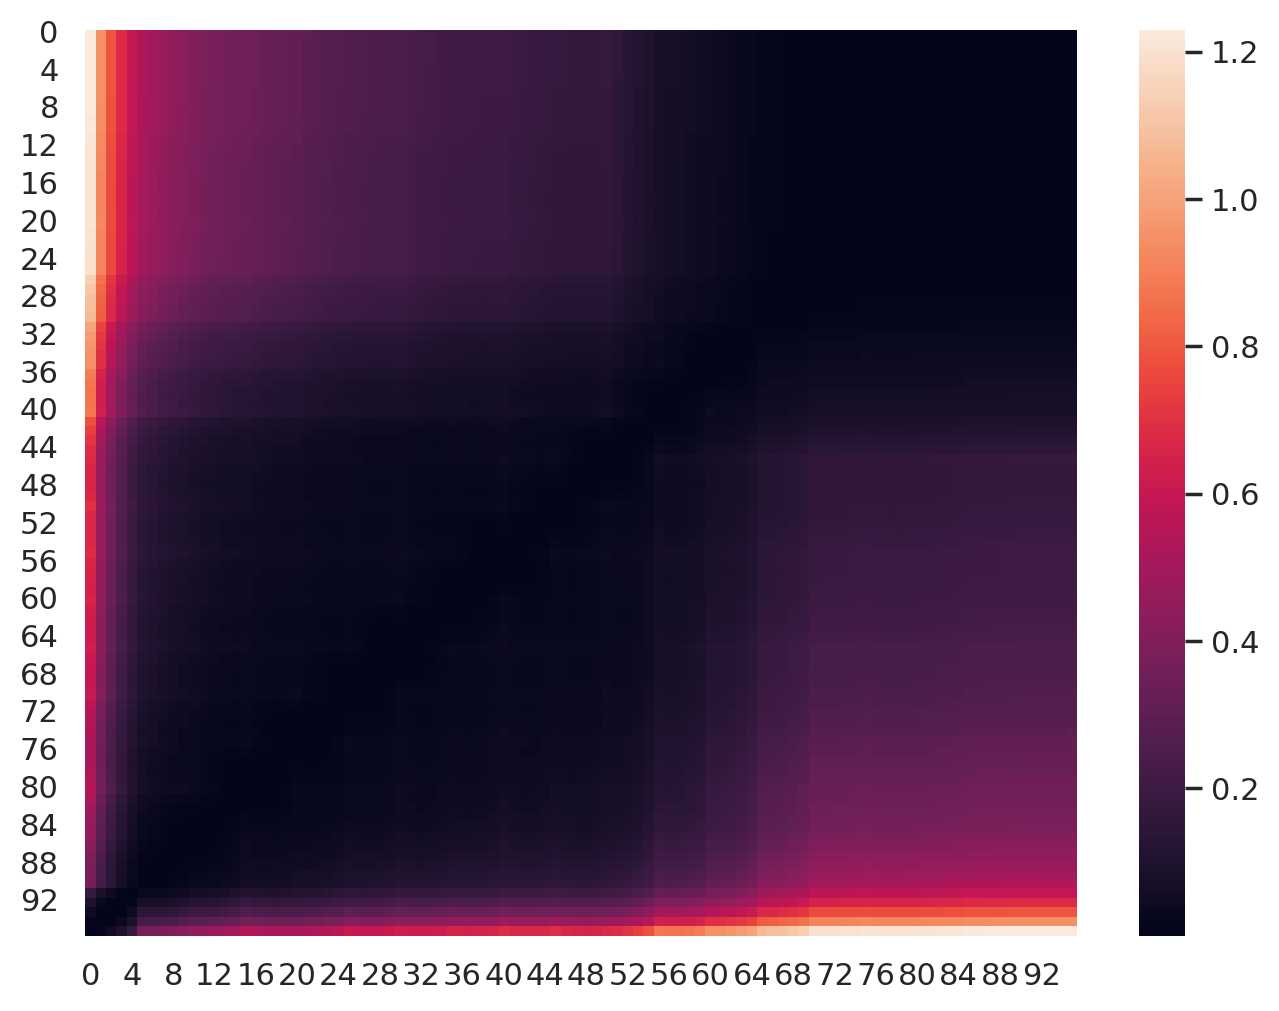

In [65]:
d0 = dists.iloc[get_idx(dists, "distf=='bhat' & s1==-1 & s2==42")]['dist'].values[0]
sns.heatmap(d0.numpy()[::-1])

<AxesSubplot:>

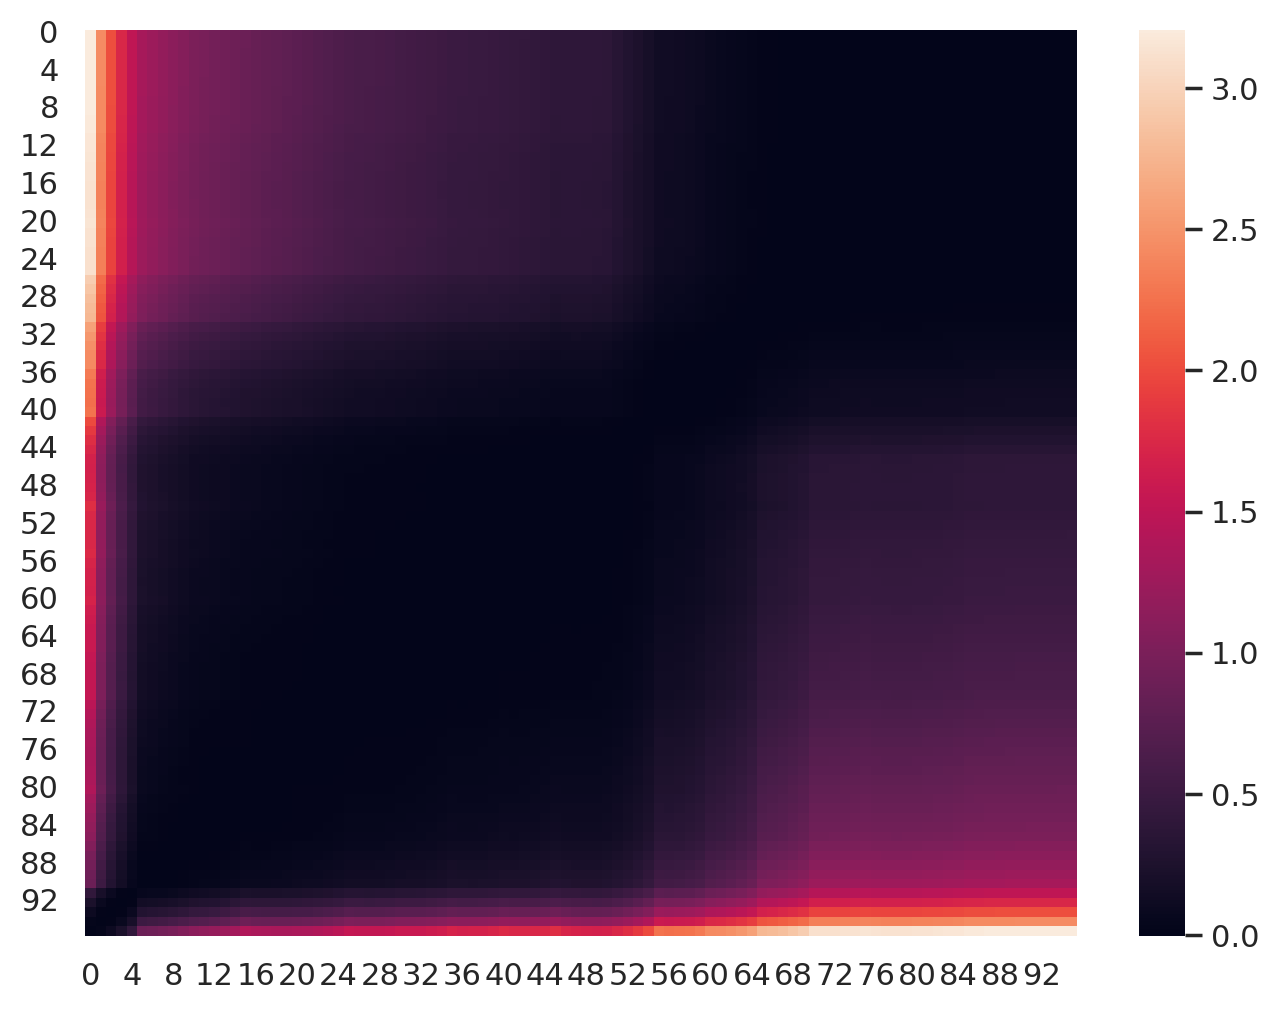

In [64]:
d0 = dists.iloc[get_idx(dists, "distf=='inpca' & s1==-1 & s2==42")]['dist'].values[0]
sns.heatmap(d0.numpy()[::-1])

## Distance to avg (dinpca)

In [66]:
dists = []
for s in np.concatenate([np.arange(0.01, 0.1, 0.05), np.arange(0.1, 1, 0.2)]):
# s = 0.1
    for k in ['yh']:
        for o in opts[:1]:
            for m in models[:1]:
                i1 = get_idx(dc, f"m=='{m}' & opt=='{o}' & avg==True")
                for seed in d['seed'].unique():
                    if seed < 0:
                        continue
                    i2 = get_idx(dc, f"m=='{m}' & opt=='{o}' & seed=={seed}")
                    di = dinpca(th.Tensor(r['xp'][i1]), th.Tensor(r['xp'][i2]), th.Tensor(np.sign(r['e'])))
                    p = th.exp(-di/(2*s)).sum(1)
                    kdist = (th.exp(-di/(2*s)) * dist).sum(1) / p
                    for i in range(N):
                        dists.append(dict(dist=kdist[i].item(), m=m, opt=o, 
                                          t=pts[i], key=k, seed=s, s=s))

Text(0.5, 1.0, 'distance to average model')

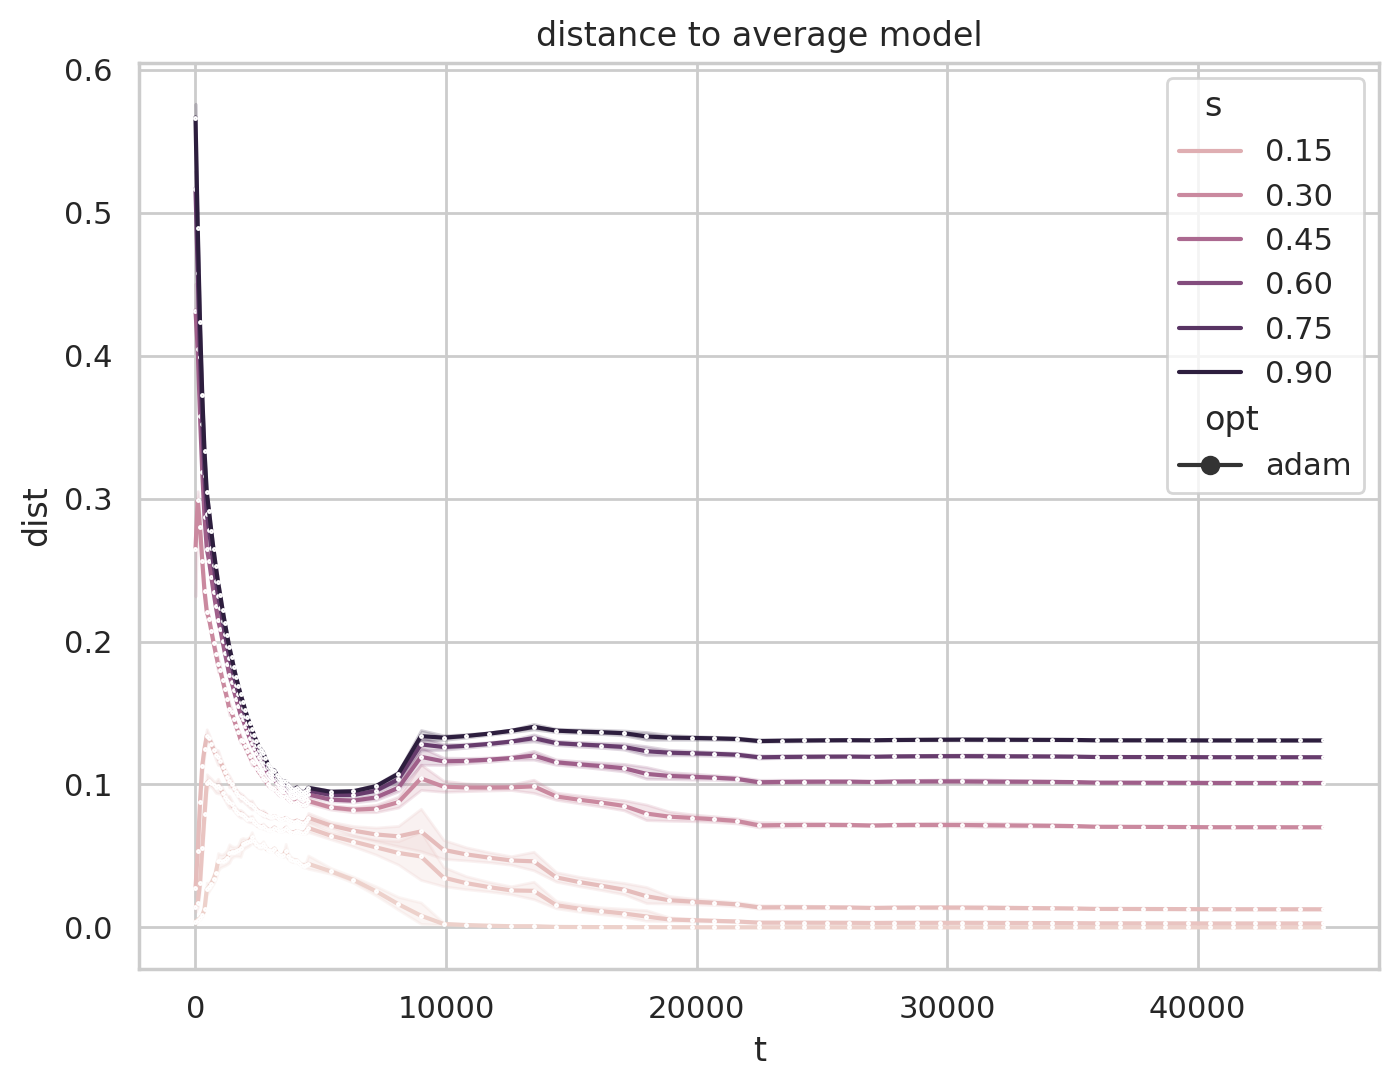

In [67]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"key=='yh'")], x='t', y='dist', hue='s', style='opt', markers=True, markersize=1)
ax.set_title('distance to average model')

In [68]:
dists = []

s = 0.1
for k in ['yh']:
    for o in opts:
        for m in models:
            i1 = get_idx(dc, f"m=='{m}' & opt=='{o}' & avg==True")
            for seed in d['seed'].unique():
                if seed < 0:
                    continue
                i2 = get_idx(dc, f"m=='{m}' & opt=='{o}' & seed=={seed}")
                di = dinpca(th.Tensor(r['xp'][i1]), th.Tensor(r['xp'][i2]), th.Tensor(np.sign(r['e'])))
                p = th.exp(-di/(2*s)).sum(1)
                kdist = (th.exp(-di/(2*s)) * dist).sum(1) / p
                for i in range(N):
                    dists.append(dict(dist=kdist[i].item(), m=m, opt=o, 
                                      t=pts[i], key=k, seed=s, s=s))

Text(0.5, 1.0, 'distance to average model')

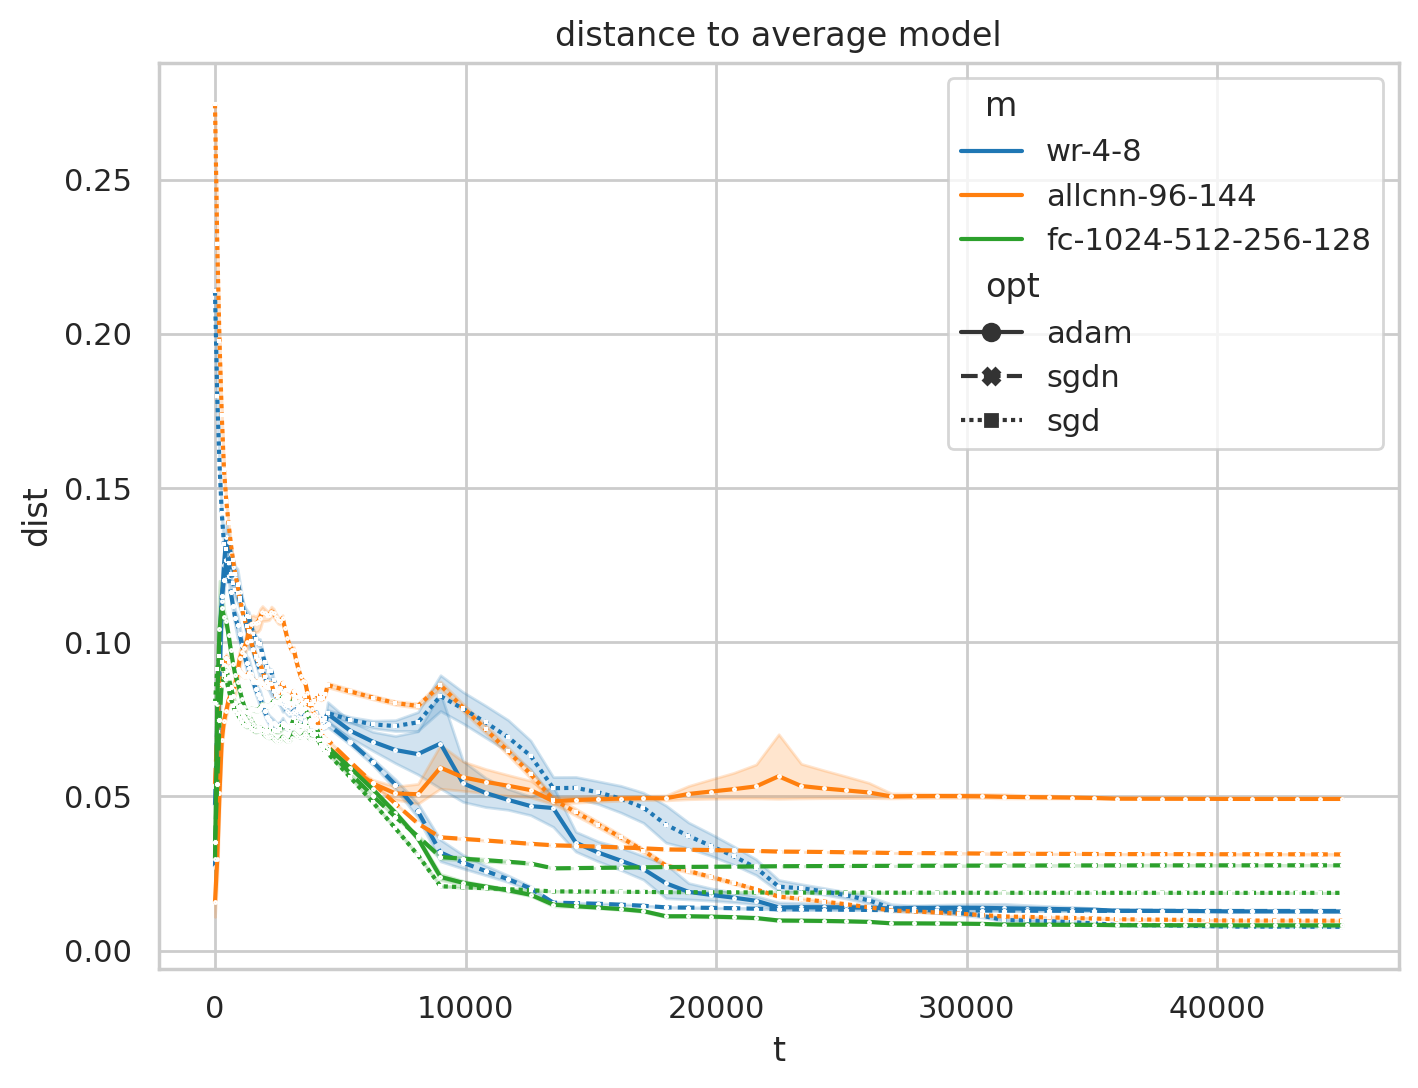

In [69]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"key=='yh'")], x='t', y='dist', hue='m', style='opt', markers=True, markersize=1)
ax.set_title('distance to average model')

## Integrating Distance

In [72]:
from distance import dt2t

In [79]:
groups = d.groupby(['m', 'opt', 'seed']).indices
configs = list(groups.keys())

In [ ]:
dists = np.zeros([T, len(configs), len(configs)])
k = 'yh'
s = 0.3
for i in range(len(configs)):
    print(i)
    for j in range(i+1, len(configs)):
        c1, c2 = configs[i], configs[j]
        x1 = th.Tensor(np.stack(d.iloc[groups[c1]]['yh'].values))
        x2 = th.Tensor(np.stack(d.iloc[groups[c2]]['yh'].values))
        dists[:, i, j], dists[:, j, i] = dt2t(x1, x2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [ ]:
data = []
d2 = np.arange(1, 11)
d1 = [22]
idxs = np.concatenate([d1, d2])
didxs=dists[:, :, idxs][:, idxs]
for t in range(len(didxs)):
    for (i, di) in enumerate(d1):
        for (j, dj) in enumerate(d2):
            d_ = didxs[t, i, len(d1)+j] + didxs[t, len(d1)+j, i]
            data.append(dict(t=t, label=(configs[di], configs[dj]), d=d_/2))
d2 = np.arange(22, 33)
d1 = [0]
idxs = np.concatenate([d1, d2])
didxs=dists[:, :, idxs][:, idxs]
for t in range(len(didxs)):
    for (i, di) in enumerate(d1):
        for (j, dj) in enumerate(d2):
            d_ = didxs[t, i, len(d1)+j] + didxs[t, len(d1)+j, i]
            data.append(dict(t=t, label=(configs[di], configs[dj]), d=d_/2))

In [ ]:
dists_sum = dists.sum(0)
dists_sym = (dists_sum + dists_sum.T)/2

In [ ]:
idxs = []
columns = []
for (i, c) in enumerate(configs):
    if not c[-1]:
        idxs.append(i)
        columns.append(c[:2])
idxs = np.array(idxs)
columns = np.stack(columns)

cidxs = np.lexsort(columns.T)
idxs = idxs[cidxs]
        
didxs=dists_sym[:, idxs][idxs]

In [ ]:
sns.heatmap(pd.DataFrame(didxs, columns=columns[cidxs], index=columns[cidxs]), xticklabels=10, yticklabels=10)

## InPCA Dist